In [1]:
## Loads data into Jupyter session from pickled file

import pickle
import pandas as pd

deserialized = open("modeldf.pickle","rb")
df = pickle.load(deserialized)

In [279]:
## Assumes 80-20 split under seed 8888 for reproducibility
## Split data into test and training sets

from random import shuffle, seed

df = df.dropna(subset=['Issue', 'Method', 'Time Elapsed'])
df['Area Code'] = df['Area Code (Source)'].apply(lambda x: 0 if isinstance(x, float) else 1)

from sklearn.preprocessing import LabelEncoder

n_bins = 5
if 'Issue Bin' in df.columns:
    df = df.drop(['Issue Category'], axis = 1)
df['Issue Bin'] = pd.cut(df['Issue DateTime UTC'].apply(lambda x: x.to_pydatetime()), n_bins)

le = LabelEncoder()
le.fit(df['Issue Bin'].apply(str).values)
if 'Issue Category' not in df.columns:
    df.insert(2, 'Issue Category', list(le.transform(df['Issue Bin'].apply(str).values)), True)
if max(df['Issue Category'].values) != n_bins - 1:
    df = df.drop(['Issue Category'], axis = 1)
    df.insert(2, 'Issue Category', list(le.transform(df['Issue Bin'].apply(str).values)), True)
    
def dataSplit(data, testPercent = 0.2, s = 8888):
    seed(s)
    identifiers = list(range(len(data)))
    shuffle(identifiers)
    stop = int(len(data) * testPercent)
    trainIds, testIds = identifiers[stop:], identifiers[:stop]
    return data.iloc[trainIds], data.iloc[testIds]

train, test = dataSplit(df)

In [280]:
train.head()

,Ticket ID,Ticket Created,Issue Category,Date of Issue,Time of Issue,Form,Method,Issue,Caller ID Number,Type of Call or Messge,...,Location (Target),Area Code (Target),Area Code (Source),Location (Source),Issue DateTime,Offset,Issue DateTime UTC,Time Elapsed,Area Code,Issue Bin
1053897,1879709,2017-08-25 14:57:21,3,08/25/2017,10:41am,Phone,Wireless (cell phone/other mobile device),Unwanted Calls,None,Prerecorded Voice,...,"(38.354966, -85.885392)",502,NaN,NaN,2017-08-25 10:41:00,-14400.0,2017-08-25 14:41:00,00:16:21,0,"(2017-06-17 13:41:24, 2018-05-03 20:31:12]"
1410826,3053121,2019-02-13 23:03:18,4,02/13/2019,5:23pm,Phone,Wired,Unwanted Calls,732-223-9036,Abandoned Calls,...,"(40.118289, -74.04013)",732,732,"(40.420721428571, -74.323679285714)",2019-02-13 17:23:00,-14400.0,2019-02-13 21:23:00,01:40:18,1,"(2018-05-03 20:31:12, 2019-03-20 03:21:00]"
1094929,2190487,2018-01-24 20:33:57,3,01/24/2018,3:19pm,Phone,Wireless (cell phone/other mobile device),Unwanted Calls,920-968-7625,Prerecorded Voice,...,"(30.508139, -84.212348)",229,920,"(43.948076, -88.281434)",2018-01-24 15:19:00,-14400.0,2018-01-24 19:19:00,01:14:57,1,"(2017-06-17 13:41:24, 2018-05-03 20:31:12]"
891244,2223930,2018-02-08 17:01:16,3,02/07/2018,12:37pm,Phone,Wired,Unwanted Calls,None,Abandoned Calls,...,"(42.808694, -88.732552)",262,NaN,NaN,2018-02-07 12:37:00,-18000.0,2018-02-07 17:37:00,23:24:16,0,"(2017-06-17 13:41:24, 2018-05-03 20:31:12]"
1182780,2143122,2018-01-03 15:54:16,3,01/03/2018,10:18am,Phone,Wired,Unwanted Calls,None,Prerecorded Voice,...,"(39.770505, -77.567557)",240,NaN,NaN,2018-01-03 10:18:00,-14400.0,2018-01-03 14:18:00,01:36:16,0,"(2017-06-17 13:41:24, 2018-05-03 20:31:12]"


In [281]:
## Testing for MultiCollinearity of Features

from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import pandas as pd

def oneHotEncode(df, column):
    dummies = pd.get_dummies(df[column])
    new = pd.concat([df, dummies], axis=1)
    return new

categorical = ['Form', 'Method', 'Issue']
oneHotEncoded = train.copy()
for category in categorical:
    oneHotEncoded = oneHotEncode(oneHotEncoded, category)
    
oneHotEncoded['Time Elapsed'] = oneHotEncoded['Time Elapsed'].apply(lambda x: x.seconds)
oneHotEncoded = oneHotEncoded._get_numeric_data()

for category in ['Ticket ID', 'Area Code (Target)', 'Offset']:
    oneHotEncoded = oneHotEncoded.drop(category, axis=1)

oneHotEncoded.columns = oneHotEncoded.columns.str.strip().str.lower().str.replace(' ', '_')

for faulty in ['(', ')', '/']:
    oneHotEncoded.columns = oneHotEncoded.columns.str.replace(faulty, ('_' if faulty == '/' else ''))

oneHotEncoded = oneHotEncoded.dropna()

In [282]:
oneHotEncoded.head()

,issue_category,time_elapsed,area_code,phone,radio,tv,amateur_radio,broadcast,cable,fiber,...,junk_faxes,loud_commercials,number_portability_keeping_your_number_if_you_change_providers,open_internet_net_neutrality,pirate_radio,privacy,robocalls,rural_call_completion,telemarketing_including_do_not_call_and_spoofing,unwanted_calls
1053897,3,981,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1410826,4,6018,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1094929,3,4497,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
891244,3,84256,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1182780,3,5776,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [283]:
%%capture
## Gather features
features = "+".join(oneHotEncoded.columns.difference(['issue_category']))

# Use y and X dataframes for regression:
y, X = dmatrices('issue_category ~' + features, oneHotEncoded, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [284]:
## Note that All VIF Factors are >10. This indicates that multicolinearity exists
## and that we should use Principle Components Analysis to reconstruct our oneHotEncoded vectors

vif.head()

,VIF Factor,features
0,0.000000,Intercept
1,inf,amateur_radio
2,1.412929,area_code
3,inf,availability
4,inf,availability_including_rural_call_completion


In [285]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, categorical):
        self.categorical = categorical
        self.data = list()
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        self.data = list()
        for row in X[self.categorical].iterrows():
            self.data.append(list(row[1].values))
        return self.data
    
featTrans = FeatureTransformer(['Form', 'Method', 'Issue', 'Area Code'])
categoricals = featTrans.transform(train)

In [286]:
## Implements OneHotEncoding on all categorical variables, stores boolean matrix in inputs

from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(categoricals)
inputs = enc.transform(categoricals)

In [287]:
## Concatenate Time Entry into input matrix X

from scipy.sparse import coo_matrix, hstack
from sklearn.preprocessing import StandardScaler
from datetime import datetime

class ConcatenateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, data, date):
        self.data = data
        self.length = len(data)
        self.scaler = StandardScaler()
        self.date = date
    
    def fit(self, X, y = None):
        self.data['Days'] = self.data['Ticket Created'].apply(lambda x: ((x-self.date).total_seconds())/(24*60*60))
        return self
    
    def transform(self, X):
        #return hstack([X, coo_matrix(self.scaler.fit_transform(self.data['Days'].values.reshape((self.length, 1))))])
        return hstack([X, coo_matrix(self.data['Days'].values.reshape((self.length, 1)))])


concat = ConcatenateTransformer(train, datetime(2015,1,1))
#inputs = concat.fit_transform(inputs)

In [288]:
inputs

<543768x32 sparse matrix of type '<class 'numpy.float64'>'
	with 2175072 stored elements in Compressed Sparse Row format>

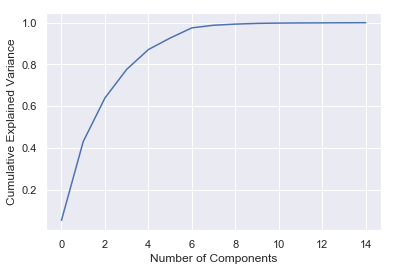

In [289]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 15)
svd.fit(inputs)
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

In [290]:
## Use n_components = 6 for SVD and use LabelEncoder to translate data into compatiable format

from sklearn.decomposition import TruncatedSVD
from datetime import datetime

scaler = StandardScaler()
svd = TruncatedSVD(n_components = 6)
X = svd.fit_transform(inputs)
#y = scaler.fit_transform(train['Time Elapsed'].apply(lambda x: x.seconds).values.reshape(-1, 1))
#y = train['Time Elapsed'].apply(lambda x: x.seconds).values.reshape(-1, 1)
y = train['Issue Category'].values

In [291]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 20, min_samples_leaf=10)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [292]:
# Training Error...
clf.score(X, y)

0.5014840888025776

In [293]:
categoricals_test = featTrans.transform(test)
inputs_test = enc.transform(categoricals_test)
#concat = ConcatenateTransformer(test, datetime(2015,1,1))
#inputs_test = concat.fit_transform(inputs_test)
#scaler = StandardScaler()
X_test = svd.transform(inputs_test)
#y_test = scaler.fit_transform(test['Time Elapsed'].apply(lambda x: x.seconds).values.reshape(-1, 1))
y_test = test['Issue Category'].values
clf.score(X_test, y_test)

0.5015705342758991

In [294]:
from sklearn.metrics import confusion_matrix

In [295]:
y

array([3, 4, 3, ..., 1, 3, 4], dtype=int64)

In [296]:
clf.predict(X)

array([4, 3, 3, ..., 1, 4, 4], dtype=int64)

In [297]:
metrics = confusion_matrix(y, clf.predict(X))

In [298]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

<Figure size 432x288 with 0 Axes>

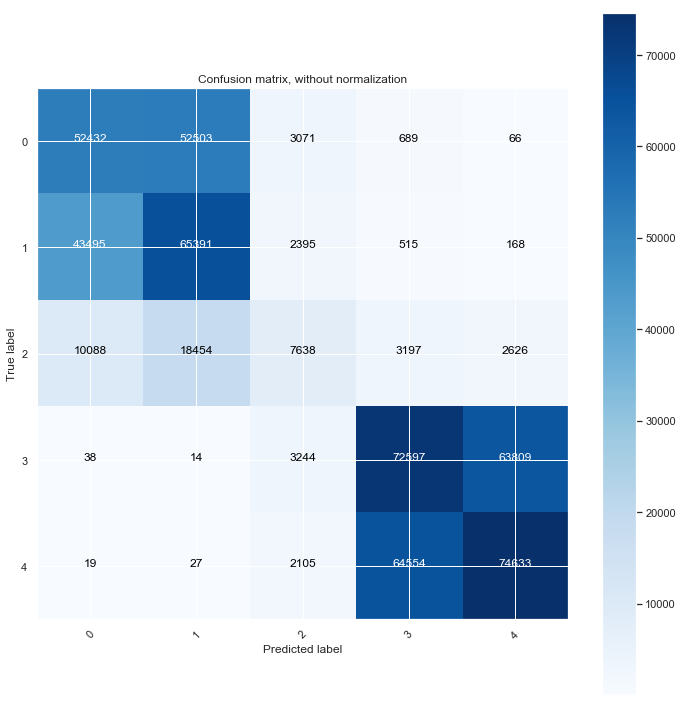

In [299]:
import itertools

# Plot non-normalized confusion matrix
plt.figure()
plt.figure(figsize=(10,10))
plot_confusion_matrix(metrics, classes = range(n_bins),
                      title='Confusion matrix, without normalization')
